# Swap Curve

In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import QuantLib as ql
import xlwings as xw

In [12]:
# Get Quote from Excel File

def GET_QUOTE(today):
    
    # import Data from Excel
    xw.App(visible=False)           # 엑셀 켜지지 않고 데이터만 켜기
    wb = xw.Book(r'Data.xlsx')      
    sht = wb.sheets('Sheet1')
    quote = sht.range("A1:D25").options(pd.DataFrame).value
    wb.close()                      # 데이터 입수 후 엑셀 종료
    
    # Pre-process DataFrame
    quote['DaysToMaturity'] = np.nan  # 현재부터 만기까지 일수 계산
    quote["Maturity"] = pd.to_datetime(quote['Maturity']).dt.date
    
    for tenor in quote.index:
        quote.loc[tenor, 'DaysToMaturity'] = (quote.loc[tenor, 'Maturity']-today).days
    return quote

In [13]:
if __name__ =="__main__":
    todays_date = datetime.date(2020, 10, 9)
    quote = GET_QUOTE(todays_date)
    print(quote)

         Maturity InstType  Market.Mid  DaysToMaturity
Tenor                                                 
3MO    2021-01-09     CASH     0.22538            92.0
6MO    2021-03-17   FUTURE    99.72500           159.0
9MO    2021-06-16   FUTURE    99.78500           250.0
12MO   2021-09-15   FUTURE    99.80000           341.0
15MO   2021-12-15   FUTURE    99.80000           432.0
18MO   2022-03-16   FUTURE    99.78000           523.0
21MO   2022-06-15   FUTURE    99.80000           614.0
2Y     2022-10-07     SWAP     0.21815           728.0
3Y     2023-10-09     SWAP     0.23010          1095.0
4Y     2024-10-09     SWAP     0.26820          1461.0
5Y     2025-10-09     SWAP     0.32795          1826.0
6Y     2026-10-09     SWAP     0.39600          2191.0
7Y     2027-10-08     SWAP     0.47055          2555.0
8Y     2028-10-09     SWAP     0.54155          2922.0
9Y     2029-10-09     SWAP     0.61050          3287.0
10Y    2030-10-09     SWAP     0.67335          3652.0
11Y    203

In [14]:
# Construct IRS Curve

def SWAP_CURVE(today, quote):
    
    # Divide DataFrame into 3 Parts
    depo = quote[quote['InstType']== 'CASH']
    futures = quote[quote['InstType']== 'FUTURE']
    swap = quote[quote['InstType'] == 'SWAP']
    
    # Set Evaluation Date ( 퀀트립 날짜로 변환 후 평가 일자 만들기 )
    todays_date = ql.Date(today.day, today.month, today.year)
    ql.Settings.instance().evaluationDate = todays_date
    
    # Market Conventions ( 시장 관행 정의 )
    calendar = ql.UnitedStates()
    dayCounter = ql.Actual360()
    convention = ql.ModifiedFollowing
    settlementDays = 2
    frequency = ql.Semiannual
    
    # Build Rate Helpers ( 시장 데이터가 존재하는 테너에 맞게 각각의 헬퍼 함수 정의 )
    # 1. Deposit Rate Helper 
    depositHelpers = [ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate / 100)),
                                          ql.Period(int(day), ql.Days),
                                          settlementDays,
                                          calendar,
                                          convention,
                                          False,
                                          dayCounter)
                     for day, rate in zip(depo['DaysToMaturity'], depo['Market.Mid'])]
    # 2. Futures Rate Helper
    futuresHelpers = []
    for i, price in enumerate(futures['Market.Mid']):
        iborStartDate = ql.Date(futures['Maturity'][i].day,
                               futures['Maturity'][i].month,
                               futures['Maturity'][i].year)
        futuresHelper = ql.FuturesRateHelper(ql.QuoteHandle(ql.SimpleQuote(price)),
                                            iborStartDate,
                                            3,
                                            calendar,
                                            convention,
                                            False,
                                            dayCounter)
        futuresHelpers.append(futuresHelper)
    
    # 3. Swap Rate Helper
    swapHelpers = [ql.SwapRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate / 100)),
                                    ql.Period(int(day), ql.Days),
                                    calendar,
                                    frequency,
                                    convention,
                                    dayCounter,
                                    ql.Euribor3M())
                    for day, rate in zip(swap['DaysToMaturity'], swap['Market.Mid'])]
    
    # Curve Construction ( 이를 하나로 연결한 뒤 다시 ql.PiecewiseLinearZero() 메서드 사용 )
    helpers = depositHelpers + futuresHelpers + swapHelpers
    depoFuturesSwapCurve = ql.PiecewiseLinearZero(todays_date, helpers, dayCounter)
    
    return depoFuturesSwapCurve

In [15]:
def DISCOUNT_FACTOR(date, curve): # 할인계수 구하기
    date = ql.Date(date.day, date.month, date.year)
    return curve.discount(date)

In [16]:
def ZERO_RATE(date, curve):
    date = ql.Date(date.day, date.month, date.year)
    day_counter = ql.Actual360()
    compounding = ql.Compounded
    freq = ql.Continuous
    zero_rate = curve.zeroRate(date,
                              day_counter,
                              compounding,
                              freq).rate()
    return zero_rate

In [20]:
def FORWARD_RATE(date, curve): # 미래 특정 기간 동안의 금리 값에 대해 현재 금리 시장이 어떻게 기대하고 있는가
    date = ql.Date(date.day, date.month, date.year)
    day_counter = ql.Actual360()
    compounding = ql.Compounded
    freq = ql.Continuous
    forward_rate = curve.forwardRate(date,
                                    date,
                                    day_counter,
                                    compounding,
                                    freq,
                                    True).rate()
    return forward_rate

       discount factor  zero rate  forward rate
Tenor                                          
3MO           0.999424   0.225410      0.225410
6MO           0.998992   0.228387      0.257972
9MO           0.998299   0.245318      0.291842
12MO          0.997756   0.237269      0.206068
15MO          0.997252   0.229428      0.198675
18MO          0.996748   0.224356      0.220702
21MO          0.996194   0.223720      0.219430
2Y            0.995593   0.218549      0.149537
3Y            0.993034   0.229967      0.265557
4Y            0.989205   0.267631      0.419185
5Y            0.983540   0.327471      0.628946
6Y            0.976198   0.396203      0.809989
7Y            0.967114   0.471717      1.003107
8Y            0.956854   0.544125      1.121218
9Y            0.945524   0.614442      1.248629
10Y           0.933515   0.679334      1.328849
11Y           0.921174   0.737180      1.373626
12Y           0.908724   0.787877      1.396333
15Y           0.871962   0.902423      1

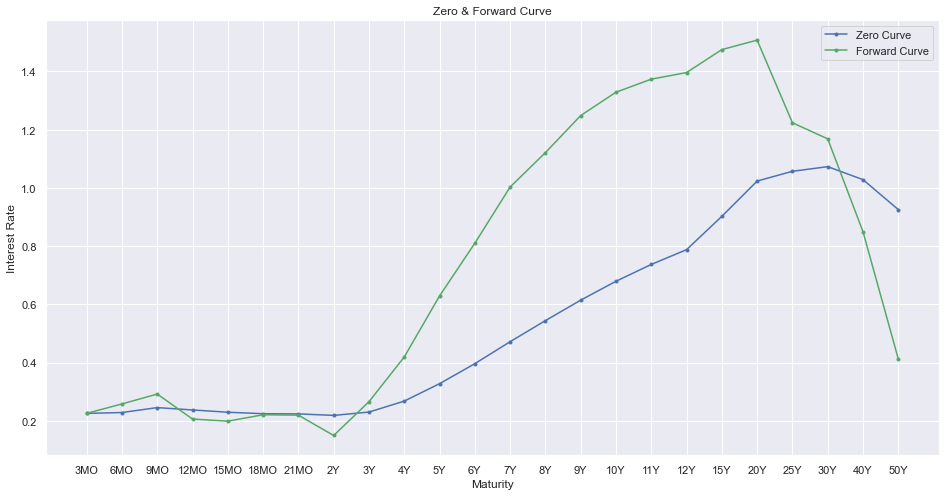

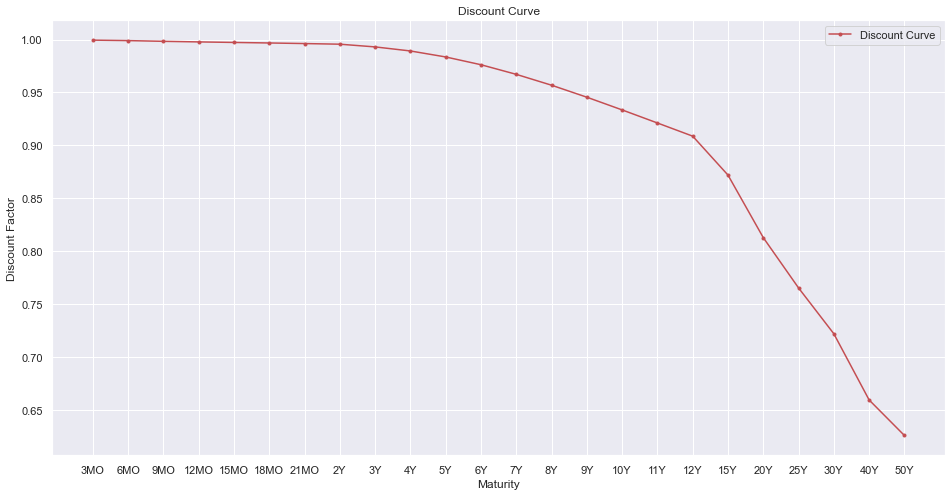

In [21]:
if __name__ =="__main__":
    
    # Today's Date
    todays_date = datetime.date(2020,10,9)
    
    # Get Quote & Build Swap Curve
    quote = GET_QUOTE(todays_date)
    curve = SWAP_CURVE(todays_date, quote)
    
    # Calculate Discount Factor / Zero Rate / Forward Rate
    quote["discount factor"]=np.nan
    quote["zero rate"]=np.nan
    quote["forward rate"]=np.nan
    
    for tenor, date in zip(quote.index, quote["Maturity"]):
        quote.loc[tenor,'discount factor']=DISCOUNT_FACTOR(date, curve)
        quote.loc[tenor,'zero rate']= ZERO_RATE(date, curve) * 100
        quote.loc[tenor,'forward rate']= FORWARD_RATE(date, curve) * 100
    
    # Print the Result
    print(quote[["discount factor", "zero rate", "forward rate"]])
    
    # Plot the Result
    plt.figure(figsize=(16,8))
    plt.plot(quote["zero rate"], 'b.-', label='Zero Curve')
    plt.plot(quote["forward rate"], 'g.-', label="Forward Curve")
    plt.title("Zero & Forward Curve", loc="center")
    plt.legend()
    plt.xlabel("Maturity")
    plt.ylabel("Interest Rate")
    
    plt.figure(figsize=(16,8))
    plt.plot(quote["discount factor"], 'r.-', label="Discount Curve")
    plt.title("Discount Curve", loc="Center")
    plt.legend()
    plt.xlabel("Maturity")
    plt.ylabel("Discount Factor")
        